In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import seaborn as sns

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.hierarchical_portfolio import HRPOpt
from pypfopt import risk_models
from pypfopt import expected_returns


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
price_month=pd.read_csv('price_panel_monthend.csv',index_col=0,parse_dates=True)
price_month.head()

,014160,003560,004370,013360,003640,005385,003547,112610,014990,013240,...,004710,170900,185750,136490,210540,267250,004105,005930,006805,006375
Date,,,,,,,,,,,,,,,,,,,,,
2008-12-30,235,1540,244500,540,14400.0,12800,5600,NaN,1015,2110.0,...,8822,NaN,NaN,NaN,NaN,NaN,326.0,9020,3613,97000.0
2009-01-30,275,1285,200500,539,14150.0,13700,6550,NaN,1005,2035.0,...,11673,NaN,NaN,NaN,NaN,NaN,290.0,9760,4671,91000.0
2009-02-27,265,1210,227000,545,12000.0,15150,6310,NaN,855,1705.0,...,12352,NaN,NaN,NaN,NaN,NaN,278.0,9540,4185,97800.0
2009-03-31,315,1170,215000,620,13600.0,18600,6520,NaN,1100,2310.0,...,18154,NaN,NaN,NaN,NaN,NaN,285.0,11360,5164,93000.0
2009-04-30,400,1360,216000,715,17650.0,20800,6950,NaN,1245,3315.0,...,16898,NaN,NaN,NaN,NaN,NaN,351.0,11840,5588,118500.0


In [34]:
def winner_construction(price_month,k,start,end):
    rtn=np.log(price_month/price_month.shift(1))*100
    mom_k=np.log(price_month/price_month.shift(k))*100
    rtn=rtn.iloc[1:]
    mom_k=mom_k.iloc[k:]
    mom_k=mom_k.shift(1)
    mom_k=mom_k.iloc[1:]
    rtn=rtn.reindex(mom_k.index)
    tickers=dict()
    for i in range(12,len(mom_k)):
        winners = mom_k.iloc[i].dropna().rank(method='first',ascending=False)\
        [(mom_k.iloc[i].dropna().rank(method='first',ascending=False)<end) & \
        ((mom_k.iloc[i].dropna().rank(method='first',ascending=False)>=start))].index.values
        winners = list(winners)
        mom_k1=mom_k[winners].copy()
        mom_k2=mom_k1[mom_k1>0]
        winners=mom_k2.iloc[i].index
        winners=list(winners)
        rtn1=rtn[winners].copy()
        hrp_weights = HRPOpt(returns=rtn1.iloc[:12+i].fillna(-99)).optimize()
        tickers[rtn1.index[i]]=\
        [[np.dot(rtn1.iloc[i].fillna(-99).values,np.array(list(hrp_weights.values())))],list(hrp_weights.keys())]
    return tickers













In [35]:
winner_sample = winner_construction(price_month=price_month, k = 6,start=100,end=200)

In [39]:
def loser_construction(price_month,k,start,end):
    rtn=np.log(price_month/price_month.shift(1))*100
    mom_k=np.log(price_month/price_month.shift(k))*100
    rtn=rtn.iloc[1:]
    mom_k=mom_k.iloc[k:]
    mom_k=mom_k.shift(1)
    mom_k=mom_k.iloc[1:]
    rtn=rtn.reindex(mom_k.index)
    tickers=dict()
    for i in range(12,len(mom_k)):
        winners = mom_k.iloc[i].dropna().rank(method='first',ascending=False)\
        [(mom_k.iloc[i].dropna().rank(method='first',ascending=False)<end) & \
        ((mom_k.iloc[i].dropna().rank(method='first',ascending=False)>=start))].index.values
        winners = list(winners)
        mom_k1=mom_k[winners].copy()
        mom_k2=mom_k1[mom_k1<0]
        winners=mom_k2.iloc[i].index
        winners=list(winners)
        rtn1=rtn[winners].copy()
        hrp_weights = HRPOpt(returns=rtn1.iloc[:12+i].fillna(-99)).optimize()
        tickers[rtn1.index[i]]=\
        [[np.dot(rtn1.iloc[i].fillna(-99).values,np.array(list(hrp_weights.values())))],list(hrp_weights.keys())]
    return tickers




In [40]:
loser_sample=loser_construction(price_month=price_month,k=6,start=800,end=900)

In [41]:
several_k=[3,6,9,12]

#winner
print('winners')
for k in several_k:
    print(str(k)+'momentum')
    k_winner_dual=winner_construction(price_month=price_month,k=k,start=100,end=200)
    for i in range((11-k),12+(11-k)):
        print(list(k_winner_dual.keys())[i])
        sub=len([x for x in k_winner_dual[list(k_winner_dual.keys())[i]][1] if x not in k_winner_dual[list(k_winner_dual.keys())[i-1]][1]])
        print(f'교체비율: {sub/len(k_winner_dual[list(k_winner_dual.keys())[i-1]][1])}')
        print('편입',[x for x in k_winner_dual[list(k_winner_dual.keys())[i]][1] if x not in k_winner_dual[list(k_winner_dual.keys())[i-1]][1]])
        print('퇴출',[x for x in k_winner_dual[list(k_winner_dual.keys())[i-1]][1] if x not in k_winner_dual[list(k_winner_dual.keys())[i]][1]])

    for i in range(len(list(k_winner_dual.keys()))-12, len(list(k_winner_dual.keys()))):
        print(list(k_winner_dual.keys())[i])
        sub=len([x for x in k_winner_dual[list(k_winner_dual.keys())[i]][1] if x not in k_winner_dual[list(k_winner_dual.keys())[i-1]][1]])
        print(f'교체비율: {sub/len(k_winner_dual[list(k_winner_dual.keys())[i-1]][1])}')
        print('편입',[x for x in k_winner_dual[list(k_winner_dual.keys())[i]][1] if x not in k_winner_dual[list(k_winner_dual.keys())[i-1]][1]])
        print('퇴출',[x for x in k_winner_dual[list(k_winner_dual.keys())[i-1]][1] if x not in k_winner_dual[list(k_winner_dual.keys())[i]][1]])


        

winners
3momentum
2010-12-30 00:00:00
교체비율: 0.74
편입 ['000070', '000120', '000155', '000157', '000325', '000800', '000990', '001687', '001799', '002785', '003030', '003160', '003480', '003640', '003720', '003920', '004000', '004010', '004380', '004410', '004490', '004700', '005090', '005380', '005385', '005387', '005430', '005870', '006090', '006380', '006840', '008060', '008350', '008355', '008600', '009140', '009410', '010520', '010580', '010955', '011160', '011170', '011390', '011780', '011785', '012205', '012630', '014580', '014820', '016090', '016575', '016610', '017390', '018470', '019175', '020760', '021820', '024720', '029460', '042660', '051310', '058650', '078930', '079660', '085310', '086790', '090370', '093820', '096770', '097230', '104110', '104120', '117930', '120115']
퇴출 ['000150', '000210', '000215', '000320', '000547', '000860', '000995', '001070', '001250', '001430', '001515', '001630', '001745', '002355', '002620', '002880', '002960', '002990', '003060', '003220', '00

In [43]:
several_k=[3,6,9,12]

#winner
print('losers')
for k in several_k:
    print(str(k)+'momentum')
    k_loser_dual=loser_construction(price_month=price_month,k=k,start=800,end=900)
    for i in range((11-k),12+(11-k)):
        print(list(k_loser_dual.keys())[i])
        sub=len([x for x in k_loser_dual[list(k_loser_dual.keys())[i]][1] if x not in k_loser_dual[list(k_loser_dual.keys())[i-1]][1]])
        print(f'교체비율: {sub/len(k_loser_dual[list(k_loser_dual.keys())[i-1]][1])}')
        print('편입',[x for x in k_loser_dual[list(k_loser_dual.keys())[i]][1] if x not in k_loser_dual[list(k_loser_dual.keys())[i-1]][1]])
        print('퇴출',[x for x in k_loser_dual[list(k_loser_dual.keys())[i-1]][1] if x not in k_loser_dual[list(k_loser_dual.keys())[i]][1]])

    for i in range(len(list(k_loser_dual.keys()))-12, len(list(k_loser_dual.keys()))):
        print(list(k_loser_dual.keys())[i])
        sub=len([x for x in k_loser_dual[list(k_loser_dual.keys())[i]][1] if x not in k_loser_dual[list(k_loser_dual.keys())[i-1]][1]])
        print(f'교체비율: {sub/len(k_loser_dual[list(k_loser_dual.keys())[i-1]][1])}')
        print('편입',[x for x in k_loser_dual[list(k_loser_dual.keys())[i]][1] if x not in k_loser_dual[list(k_loser_dual.keys())[i-1]][1]])
        print('퇴출',[x for x in k_loser_dual[list(k_loser_dual.keys())[i-1]][1] if x not in k_loser_dual[list(k_loser_dual.keys())[i]][1]])


        

losers
3momentum
2010-12-30 00:00:00
교체비율: 0.71
편입 ['000100', '000327', '000590', '001040', '001065', '001360', '001380', '001520', '001525', '001527', '002300', '002535', '002630', '003190', '003450', '003470', '004100', '004150', '004840', '004940', '004987', '004989', '005350', '005360', '005420', '005690', '006260', '006280', '006340', '006440', '007197', '007610', '007630', '008260', '008540', '009275', '009320', '009385', '010060', '010120', '010960', '011155', '011230', '011760', '011800', '012400', '014440', '014910', '014915', '015020', '015260', '017960', '020000', '023960', '024890', '025750', '031820', '034310', '034830', '051600', '052690', '068870', '071090', '091090', '093370', '094280', '102260', '102280', '103155', '109070', '128940']
퇴출 ['000370', '000700', '000760', '000810', '001200', '001210', '001440', '001529', '001680', '002070', '002320', '002460', '002550', '002700', '003495', '003680', '004060', '004130', '004370', '004550', '004830', '004990', '005030', '005

In [46]:
start = '2008-12-01'
end = '2021-11-30'

In [47]:
import pandas_datareader.naver as web_naver
kospi=web_naver.NaverDailyReader(symbols='KOSPI', start=start,end=end,adjust_price=True)
kospi=kospi.read()
kospi=kospi.astype(float)

In [48]:
kospi=kospi.loc[price_month.index,:]['Close']
kospi

Date
2008-12-30    1124.47
2009-01-30    1162.11
2009-02-27    1063.03
2009-03-31    1206.26
2009-04-30    1369.36
               ...   
2021-07-30    3202.32
2021-08-31    3199.27
2021-09-30    3068.82
2021-10-29    2970.68
2021-11-30    2839.01
Name: Close, Length: 156, dtype: float64

In [49]:
from tqdm import tqdm
several_k = [3,6,9,12]

portfolio = pd.DataFrame(index = price_month.index)

for k in tqdm(several_k):
  winner_k = winner_construction(price_month = price_month, k = k,start=100,end=200)
  loser_k = loser_construction(price_month = price_month, k = k,start=800,end=900)
  portfolio['winner'+str(k)] = pd.Series(np.array([rtn[0] for rtn in list(winner_k.values())]).flatten(), index = winner_k.keys())
  portfolio['loser'+str(k)] =  pd.Series(np.array([rtn[0] for rtn in list(loser_k.values())]).flatten(), index = loser_k.keys())

portfolio['KOSPI'] = (np.log(kospi/kospi.shift(1))) * 100 

portfolio = portfolio.iloc[13:]

100%|██████████| 4/4 [15:32<00:00, 233.19s/it]


In [50]:
print("mean","\n",portfolio.mean())
print("")
print("std","\n",portfolio.std())
print("")
print("skewness","\n",portfolio.skew())
print("")
print("kurtosis","\n",portfolio.kurtosis())
print("")
print("sharpe ratio","\n", portfolio.mean() / portfolio.std())

mean 
 winner3    -0.119182
loser3     -0.477966
winner6     0.136802
loser6      0.305351
winner9     0.353799
loser9     -0.483545
winner12    0.287379
loser12    -0.291316
KOSPI       0.365744
dtype: float64

std 
 winner3     5.492166
loser3      6.840385
winner6     4.988270
loser6      8.022752
winner9     5.783477
loser9      7.074150
winner12    5.658790
loser12     7.612923
KOSPI       4.201275
dtype: float64

skewness 
 winner3    -0.500319
loser3     -0.446927
winner6    -0.533053
loser6      1.074123
winner9    -0.390832
loser9      0.337950
winner12   -0.537974
loser12    -0.051992
KOSPI      -0.338658
dtype: float64

kurtosis 
 winner3     0.990281
loser3      1.193613
winner6     1.176697
loser6      4.983302
winner9     0.395561
loser9      1.372834
winner12    1.345146
loser12     1.651106
KOSPI       1.676392
dtype: float64

sharpe ratio 
 winner3    -0.021700
loser3     -0.069874
winner6     0.027425
loser6      0.038061
winner9     0.061174
loser9     -0.068354
winn

<AxesSubplot:xlabel='Date'>

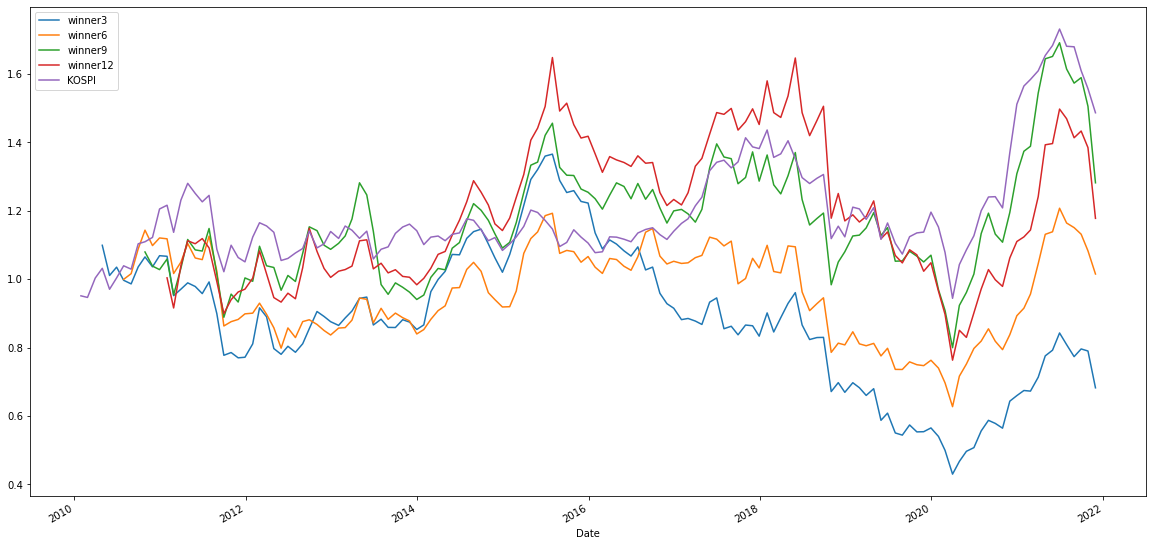

In [53]:
##winners
winners = portfolio[['winner3','winner6','winner9','winner12','KOSPI']] / 100
(1+winners).cumprod().plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

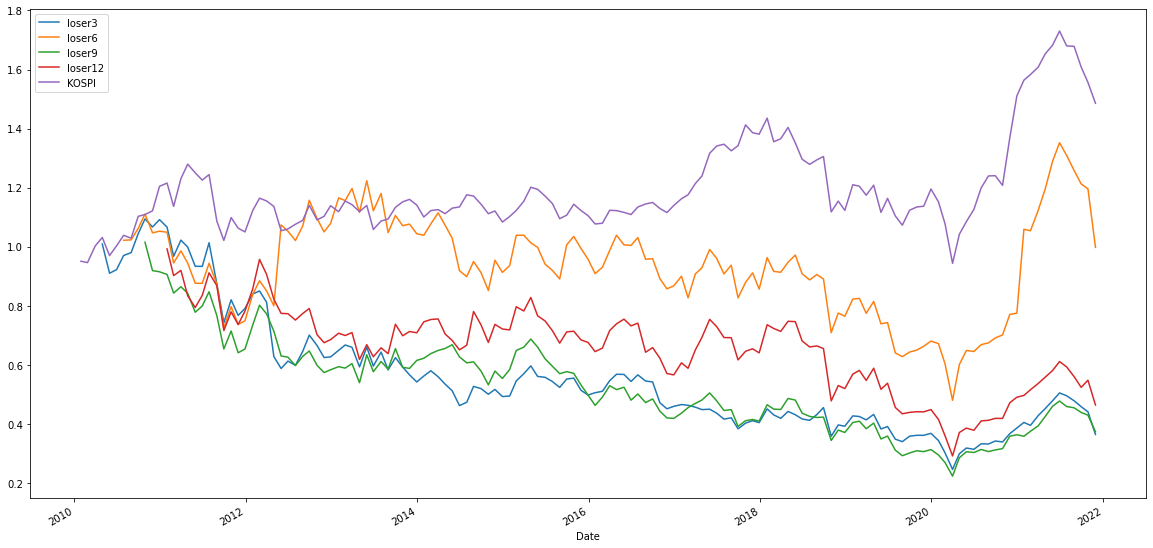

In [54]:
##losers
losers = portfolio[['loser3','loser6','loser9','loser12','KOSPI']]
(1+(losers/100)).cumprod().plot(figsize=(20,10))